In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 3.4MB 8.2MB/s 
     |████████████████████████████████| 1.1MB 9.0MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 22.5MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 706kB 54.4MB/s 
     |████████████████████████████████| 174kB 56.3MB/s 
     |████████████████████████████████| 645kB 51.9MB/s 
     |████████████████████████████████| 358kB 56.8MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix

import pandas as pd
import numpy as np

In [ ]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt

In [ ]:
#FROM TPU NOTEBOOK
try:
  os.environ['COLAB_TPU_ADDR']
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
except:
  tf.test.is_gpu_available()
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU


In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir) 

84131840/84125825 [==============================] - 1s 0us/step


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_test = ['my dog ate my homework']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1139  3676  8756  1139 22232   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]


In [ ]:
bert_results = bert_model(text_preprocessed)
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :5]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :2]}')

Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.8912889  -0.45608547 -0.5110186   0.7895845   0.2725722 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.3475421   0.33870688 -0.4383992  ... -0.32315642  0.31844342
   0.54534644]
 [-0.01640848  0.6780515   0.19745041 ... -0.7046051   0.5850279
   0.32707348]]


- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning use the `pooled_output` array.

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
#you can use the pretrained model without fine-tuning
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(["this blew worse than the arctic wind"]))
print(tf.sigmoid(bert_raw_result))

In [ ]:
tf.keras.utils.plot_model(classifier_model)

#### Loss function

Binary classification problem and the model outputs a probability (a single-unit layer). BinaryCrossentropy` loss function.


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 1 #tried 5 but it overfit
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=df_train, #train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3


ValueError: ignored

In [ ]:
path = '/content/drive/My Drive/data/IMDB_Dataset.csv'
df = pd.read_csv(path)
df['label'] = (df['sentiment']=='positive').astype(int)
df.rename({'review': 'text'}, axis=1, inplace=True)
df.drop('sentiment', axis=1, inplace=True)

df_train, df_valid = train_test_split(df, test_size=0.2)

###BASELINE

In [ ]:
train_texts = []
for t in df_train['text']:
  train_texts.append(t)

test_texts = []
for t in df_valid['text']:
  test_texts.append(t)

train_labels = []
for t in df_train['label']:
  train_labels.append(t)

test_labels = []
for t in df_valid['label']:
  test_labels.append(t)

In [ ]:
#get true test labels and reviews
y_train, X_train, y_test, X_test = [], [], [], []

for text_batch, label_batch in train_ds:
  for i in range(batch_size):
    y_train.append(label_batch.numpy()[i])
    X_train.append(text_batch.numpy()[i])
#last batch is small and causes error
for text_batch, label_batch in test_ds.take(int(20000/batch_size)): 
  for i in range(batch_size):
    y_test.append(label_batch.numpy()[i])
    X_test.append(text_batch.numpy()[i])

In [ ]:
mindf = .04
maxdf = .7
X_train = train_texts
vectorizer = TfidfVectorizer(min_df=mindf, max_df=maxdf, stop_words="english")
X_train = vectorizer.fit_transform(X_train)

In [ ]:
X_train = StandardScaler().fit_transform(X_train.todense())

In [ ]:
y_train = train_labels
lr = LogisticRegression().fit(X_train, y_train)

In [ ]:
len(lr.coef_[0])

332

In [ ]:
X_test = test_texts
vectorizer = TfidfVectorizer(min_df=mindf, max_df=maxdf, stop_words="english", max_features=len(lr.coef_[0]))
X_test = vectorizer.fit_transform(X_test)
X_test = StandardScaler().fit_transform(X_test.todense())

In [ ]:
X_test.shape, X_train.shape

((10000, 332), (40000, 332))

In [ ]:
y_test = test_labels
#stops complaint about different features, is this kosher?
#X_train = np.pad(X_train, (0, 337-332))


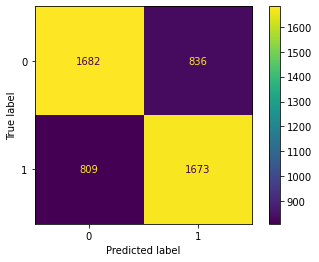

In [ ]:
subsample = 5000
plot_confusion_matrix(lr, X_test[:subsample], y_test[:subsample], values_format="")

### Evaluate 

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 271s 346ms/step - loss: 0.2944 - binary_accuracy: 0.8686
Loss: 0.29439908266067505
Accuracy: 0.8686000108718872


In [ ]:
tf.sigmoid(reloaded_model(tf.constant(["great"])))>.5

<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[ True]])>

In [ ]:
#y_preds = []
batch = 25
for i in range(100):
  if i%10 == 0: print(f"Batch: {i}")
  subtexts = texts[i*batch:(i+1)*batch] #batches of 25
  y_preds.append(tf.sigmoid(reloaded_model(tf.constant(subtexts))) > .5) #True if proba. > .5

In [ ]:
predictions = []
for i in range(100):
  for j in range(25):
    if y_preds[i][j] == True:
      predictions.append(1)
    else:
      predictions.append(0)
predictions = np.array(predictions)
predictions[:10]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 0]

In [ ]:
#look at mistakes
error_arr = []
diff = labels != predictions
for ix, t in enumerate(diff):
  if t == 1:
    error_arr.append([labels[ix], predictions[ix], texts[ix]])
error_df = pd.DataFrame(error_arr, columns=["Actual", "Predicted", "Review"])
error_df = error_df.sort_values("Actual")
error_df.reset_index(inplace=True)
error_df.tail()

,index,Actual,Predicted,Review
297,145,1,0,"b""Everyone told me this movie was downright no..."
298,146,1,0,"b""I've never watched a file in a language I do..."
299,149,1,0,b'I have no idea why everyone hates this movie...
300,153,1,0,"b'(Very mild spoilers; a basic plot outline, n..."
301,150,1,0,"b""The worst movie ever?? HARDLY!!! This is one..."


In [ ]:
lengths = []
for ix,_ in enumerate(texts):
  lengths.append(len(texts[ix].split()))
lengths.sort()

In [ ]:
error_df.to_csv(gs_folder_bert + "bert_misclassified.csv")

In [ ]:
con_mat = tf.math.confusion_matrix(labels, predictions)
con_mat_df = pd.DataFrame(con_mat)
con_mat_df

,0,1
0,"tf.Tensor(1109, shape=(), dtype=int32)","tf.Tensor(171, shape=(), dtype=int32)"
1,"tf.Tensor(131, shape=(), dtype=int32)","tf.Tensor(1089, shape=(), dtype=int32)"


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

con_mat_df = pd.DataFrame(np.array([[1109, 171],[131, 1089]]), columns=["negative", "positive"], index=["negative", "positive"])
con_mat_df

,negative,positive
negative,1109,171
positive,131,1089


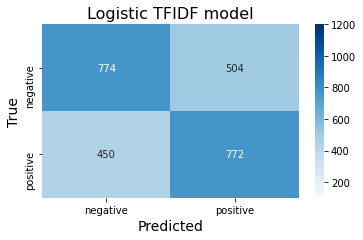

In [ ]:
#baseline
con_mat_df_base = pd.DataFrame(np.array([[774, 504],[450, 772]]), columns=["negative", "positive"], index=["negative", "positive"])
f,ax = plt.subplots(figsize=(5, 3))
sns.heatmap(con_mat_df_base, annot=True, vmax=1200, vmin=100, cmap=plt.cm.Blues,fmt='g')
plt.tight_layout()
ax.set_title('Logistic TFIDF model', fontsize=16)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
plt.show()
#plt.savefig(gs_folder_bert + "baseline.png")

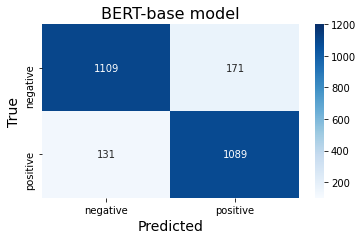

In [ ]:
f,ax = plt.subplots(figsize=(5, 3))
sns.heatmap(con_mat_df, annot=True, vmax=1200, vmin=100, cmap=plt.cm.Blues,fmt='g')
plt.tight_layout()
ax.set_title('BERT-base model', fontsize=16)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
plt.show()
#plt.savefig(gs_folder_bert + "bert.png")

In [ ]:
gs_folder_bert = '/content/drive/My Drive/bert_imdb_model'
#classifier_model.save(gs_folder_bert, include_optimizer=False)

'\npreprocess_inputs = bert_preprocess_model.inputs\nbert_encoder_inputs = bert_preprocess_model(preprocess_inputs)\nbert_outputs = classifier_model(bert_encoder_inputs)\nmodel_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)\n'

In [ ]:
gs_folder_bert = '/content/drive/My Drive/bert_imdb_model'
reloaded_model = tf.saved_model.load(gs_folder_bert, compile=True)

In [ ]:
my_review = ["this was okay and great and not good"]
raw = reloaded_model(tf.constant(my_review))
print(raw, tf.sigmoid(raw))

tf.Tensor([[0.25042593]], shape=(1, 1), dtype=float32) tf.Tensor([[0.5622813]], shape=(1, 1), dtype=float32)
